In [1]:
from pathlib import Path

import librosa
import numpy
import pysptk
import pyworld

from become_yukarin.config import create_from_json as create_config
from become_yukarin.data_struct import Wave
from become_yukarin.dataset.dataset import *
from become_yukarin.dataset.utility import MFCCAligner, DTWAligner

from IPython.display import Audio
import matplotlib.pyplot as plt
%matplotlib inline

/Users/kazuyuki_hiroshiba/.pyenv/versions/miniconda3-latest/envs/become-yukarin/lib/python3.6/site-packages/chainer/_environment_check.py:38: UserWarning: Accelerate has been detected as a NumPy backend library.
vecLib, which is a part of Accelerate, is known not to work correctly with Chainer.
We recommend using other BLAS libraries such as OpenBLAS.
For details of the issue, please see
https://docs.chainer.org/en/stable/tips.html#mnist-example-does-not-converge-in-cpu-mode-on-mac-os-x.

Also note that Chainer does not officially support Mac OS X.
Please use it at your own risk.

  ''')  # NOQA


In [2]:
paths = [
    Path('~/dataset/hiho-pause-atr503-subset/').expanduser() / 'hiho-pause-atr-A01.wav',
    Path('~/dataset/yukari-pause-atr503-subset/').expanduser() / 'yukari-pause-atr-A01.wav',
]

wave_file_load = WaveFileLoadProcess(
    sample_rate=24000,
    top_db=None,
    pad_second=0.05,
)
acoustic_feature = AcousticFeatureProcess(
    frame_period=5,
    order=36,
    alpha=pysptk.util.mcepalpha(wave_file_load._sample_rate),
)

In [3]:
w1 = wave_file_load(paths[0], test=True)
f1 = acoustic_feature(w1, test=True)

w2 = wave_file_load(paths[1], test=True)
f2 = acoustic_feature(w2, test=True)

In [4]:
aligner = MFCCAligner(f1.mfcc, f2.mfcc)

f0_1, f0_2 = aligner.align(f1.f0, f2.f0)
spectrogram_1, spectrogram_2 = aligner.align(f1.spectrogram, f2.spectrogram)
aperiodicity_1, aperiodicity_2 = aligner.align(f1.aperiodicity, f2.aperiodicity)
mfcc_1, mfcc_2 = aligner.align(f1.mfcc, f2.mfcc)
voiced_1, voiced_2 = aligner.align(f1.voiced, f2.voiced)

f1 = AcousticFeature(
    f0=f0_1,
    spectrogram=spectrogram_1,
    aperiodicity=aperiodicity_1,
    mfcc=mfcc_1,
    voiced=voiced_1,
)
f2 = AcousticFeature(
    f0=f0_2,
    spectrogram=spectrogram_2,
    aperiodicity=aperiodicity_2,
    mfcc=mfcc_2,
    voiced=voiced_2,
)

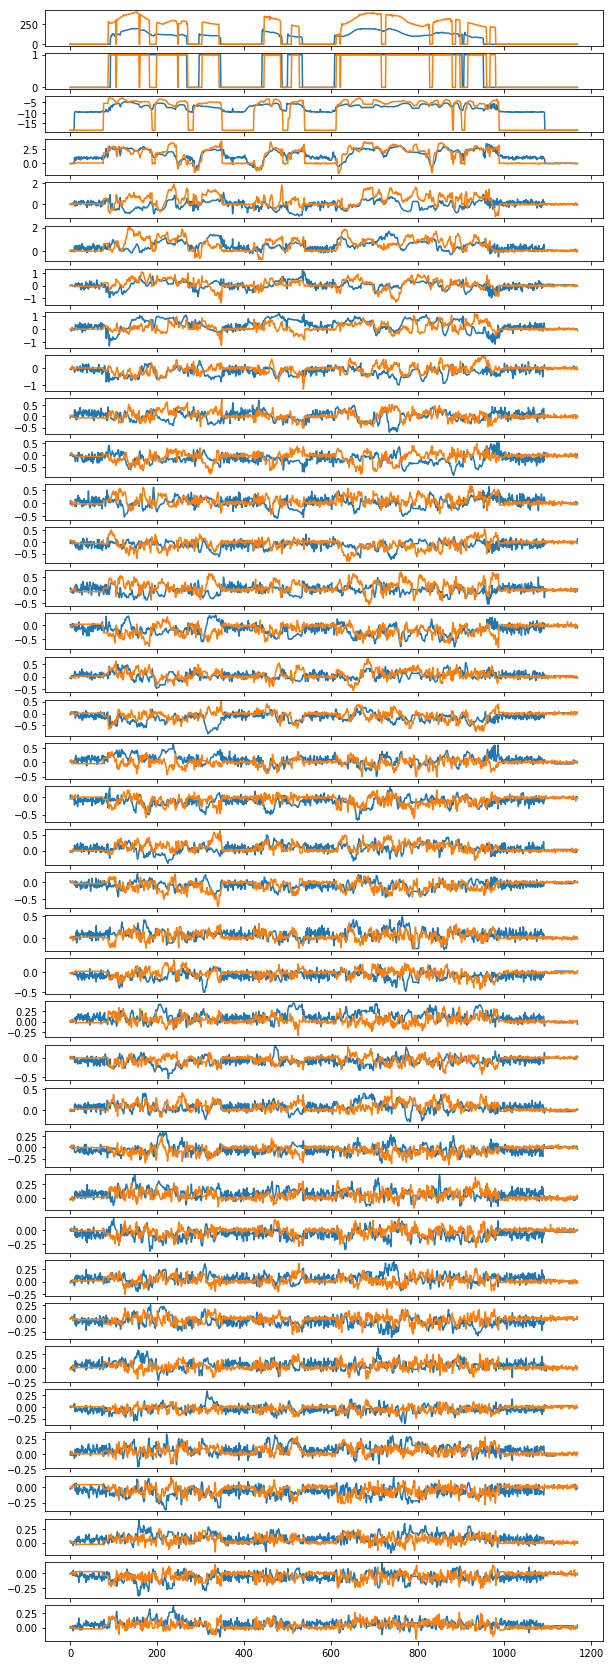

In [5]:
plt.figure(figsize=(10, 30))
ny = 2 + acoustic_feature._order

plt.subplot(ny, 1, 1)
plt.plot(f1.f0)
plt.plot(f2.f0)

plt.subplot(ny, 1, 2)
plt.plot(f1.f0!=0)
plt.plot(f2.f0!=0)

for i in range(acoustic_feature._order):
    plt.subplot(ny, 1, i+3)
    plt.plot(f1.mfcc[:,i])
    plt.plot(f2.mfcc[:,i])

In [6]:
def make_wave(f):
    fftlen = pyworld.get_cheaptrick_fft_size(wave_file_load._sample_rate)

    spectrogram = pysptk.mc2sp(
        f.mfcc,
        alpha=acoustic_feature._alpha,
        fftlen=fftlen,
    )

    f = AcousticFeature(
        f0=f.f0,
        spectrogram=spectrogram,
        aperiodicity=f.aperiodicity,
        mfcc=f.mfcc,
        voiced=f.voiced,
    ).astype(numpy.float64)

    out = pyworld.synthesize(
        f0=f.f0.ravel(),
        spectrogram=f.spectrogram,
        aperiodicity=f.aperiodicity,
        fs=wave_file_load._sample_rate,
        frame_period=acoustic_feature._frame_period,
    )
    return out

In [7]:
Audio(data=make_wave(f1), rate=wave_file_load._sample_rate)

In [8]:
Audio(data=make_wave(f2), rate=wave_file_load._sample_rate)